In [15]:
from icecream import ic
import pandas as pd
from dateutil.relativedelta import relativedelta
# from dhs_preprocessing_functions import *
# from pandarallel import pandarallel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import xgboost as xgb
from pdpbox import pdp, get_example, info_plots
import plotly.io as py

%matplotlib inline
# Initialization
# pandarallel.initialize()


from dhs_modelling_functions import final_ds_droping_cols, fold_generator

In [16]:
input_dir = "/mnt/datadisk/data/Projects/water/inputs/"
# min_version = 3
overwrite_pqt = True
dataset_type = 'HR'  #, 'BR', 'CR', 'HW', 'IR', 'KR', 'MR', 'PR', 'AR'] ??['AN', 'FC, 'FP', 'HW', 'PV', 'SC'] < 25 surveys
urban_rural_all_mode = 'all' # 'all', 'U', 'R'
group_by_col = 'adm2_gaul'
out_f = f"{input_dir}5_grouped_df_V3_{dataset_type}_{group_by_col}_joined_with_ipc_{urban_rural_all_mode}.pkl"

# Scale options
scale_numerical_data = False
scale_all_data = True
leave_out_encodings = True
zero_one_scale_categorical = False
scale_labels = True

# More Options
drop_agriculture = False



in_f = f"{input_dir}5_grouped_df_V3_{dataset_type}_{group_by_col}_joined_with_ipc_{urban_rural_all_mode}.pkl"

In [17]:
input_df = pd.read_pickle(in_f)

for c in input_df.columns:
    if 'year' in c or 'Year' in c:
        print(c)

# if urban_rural_all_mode == 'U':
#     drop_agriculture = True
    
df = final_ds_droping_cols(input_df, drop_meta=True, drop_food_help=True, drop_perc=40,
                           retain_month=False, drop_highly_correlated_cols=False, drop_region=True, 
                 drop_data_sets=['Meta one-hot encoding', 'Meta frequency encoding'], 
                 use_NAN_amount_and_replace_NANs_in_categorical=False, drop_agricultural_cols=drop_agriculture, 
                 drop_below_version=False, numerical_data=['mean'], retain_adm=False, 
                 retain_GEID_init=False, verbose=3)

for col in df.columns:
    print(col)

Meta; year
DHS Cat; person fetching water: female child under 15 years old
DHS Cat; person fetching water: male child under 15 years old
Dropped Meta one-hot encoding; data: ['Meta one-hot encoding; adm0_gaul: Angola', 'Meta one-hot encoding; adm0_gaul: Benin', 'Meta one-hot encoding; adm0_gaul: Burkina Faso', 'Meta one-hot encoding; adm0_gaul: Burundi', 'Meta one-hot encoding; adm0_gaul: Cameroon', 'Meta one-hot encoding; adm0_gaul: Central African Republic', 'Meta one-hot encoding; adm0_gaul: Chad', 'Meta one-hot encoding; adm0_gaul: Comoros', "Meta one-hot encoding; adm0_gaul: Côte d'Ivoire", 'Meta one-hot encoding; adm0_gaul: Democratic Republic of the Congo', 'Meta one-hot encoding; adm0_gaul: Egypt', 'Meta one-hot encoding; adm0_gaul: Ethiopia', 'Meta one-hot encoding; adm0_gaul: Gabon', 'Meta one-hot encoding; adm0_gaul: Gambia', 'Meta one-hot encoding; adm0_gaul: Ghana', 'Meta one-hot encoding; adm0_gaul: Guinea', 'Meta one-hot encoding; adm0_gaul: Kenya', 'Meta one-hot encodin

Dropped numerical data: ['DHS Num; number of household members: median', 'DHS Num; number of household members: std', 'DHS Num; number of household members: skewness', 'DHS Num; number of household members: kurtosis', 'DHS Num; owns sheep: median', 'DHS Num; owns sheep: std', 'DHS Num; owns sheep: skewness', 'DHS Num; owns sheep: kurtosis', 'DHS Num; number of eligible children for height and weight: median', 'DHS Num; number of eligible children for height and weight: std', 'DHS Num; number of eligible children for height and weight: skewness', 'DHS Num; number of eligible children for height and weight: kurtosis', 'DHS Num; total adults measured: median', 'DHS Num; total adults measured: std', 'DHS Num; total adults measured: skewness', 'DHS Num; total adults measured: kurtosis', 'DHS Num; number of mosquito bed nets: median', 'DHS Num; number of mosquito bed nets: std', 'DHS Num; number of mosquito bed nets: skewness', 'DHS Num; number of mosquito bed nets: kurtosis', 'DHS Num; clus

In [18]:
# Define RMSE
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [19]:
label_df = df[[c for c in df.columns if 'FS; IPC' in c]]
input_df2 = df.drop(columns=[c for c in df.columns if 'FS; IPC' in c])
num_cols = [c for c in input_df2.columns if 'DHS Num;' in c or c == 'Meta; Year' or c == 'Meta; Month']

0 FS; IPC: 2-6y: mean 15252
lens 1049 1049
cols 99
['MWGE7AFL' 'NGGE7BFL' 'UGGE7AFL' 'ZWGE72FL']
['BUGE71FL' 'CMGE71FL']
Epoch 1/30


 1/28 [>.............................] - ETA: 5s - loss: 1.0029 - root_mean_squared_error: 1.0015
Epoch 1: val_loss improved from inf to 1.37882, saving model to best_model.h5
28/28 [==============================] - 0s 5ms/step - loss: 0.8440 - root_mean_squared_error: 0.8797 - val_loss: 1.3788 - val_root_mean_squared_error: 1.1471
Epoch 2/30
 1/28 [>.............................] - ETA: 0s - loss: 0.3442 - root_mean_squared_error: 0.5867
Epoch 2: val_loss did not improve from 1.37882
28/28 [==============================] - 0s 2ms/step - loss: 0.4750 - root_mean_squared_error: 0.6564 - val_loss: 1.7802 - val_root_mean_squared_error: 1.3155
Epoch 3/30
 1/28 [>.............................] - ETA: 0s - loss: 0.3908 - root_mean_squared_error: 0.6251
Epoch 3: val_loss did not improve from 1.37882
28/28 [==============================] - 0s 2ms/step - loss: 0.3388 - root_mean_squared_error: 0.5786 - val_loss: 1.7543 - val_root_mean_squared_error: 1.3058
Epoch 4/30
 1/28 [>................

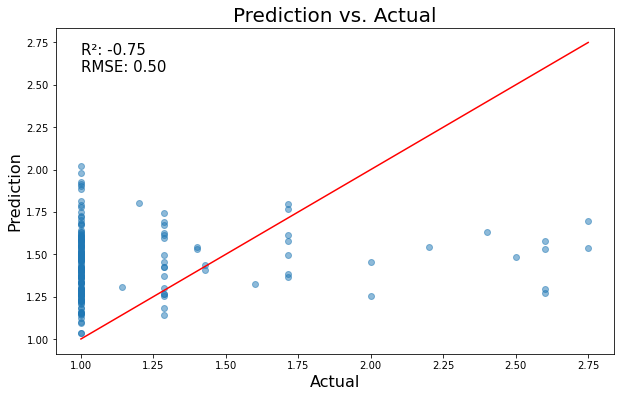

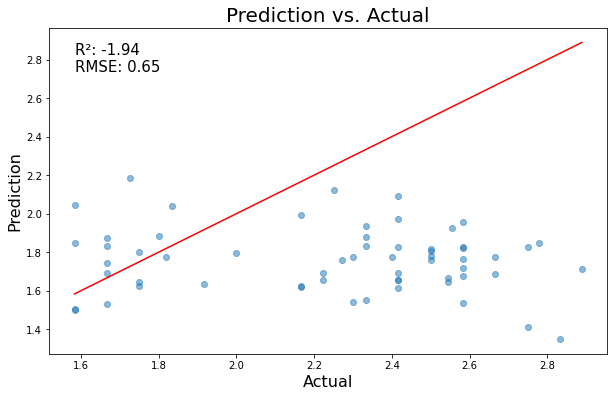

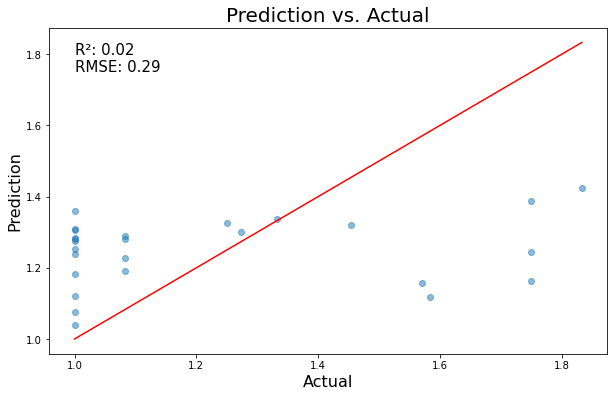

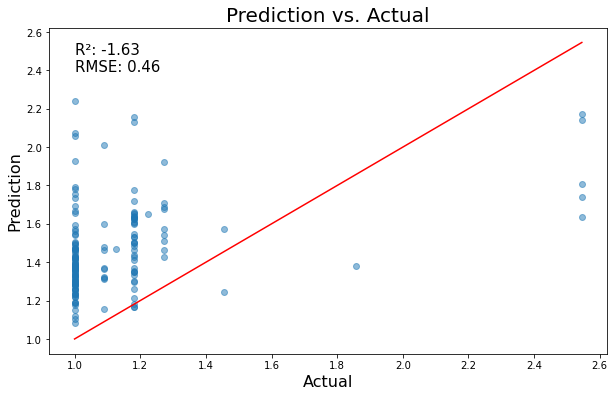

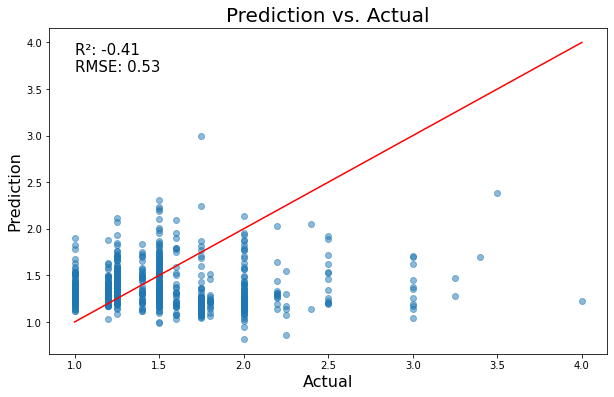

In [31]:
###XGB
label_cols = [c for c in df.columns if 'FS; IPC' in c]
scaler_l = []
history_l = []
y_test_l = []
y_pred_l = []
model_l = []
amount_inputs = []
amount_cols = []

# Options
model_n = 'nn'
fold_by = 'survey'
print_col = 'Meta; GEID_init'

for nr, col in enumerate(label_cols[1:2]):
    print(nr, col, len(df[col]))
    labels = df[col]
    labels = labels.dropna()
    # labels = labels[labels < 4]
    labels_ind = labels.index
    scaler = False
    if scale_labels:
        # scale the labels
        scaler = StandardScaler()
        labels = scaler.fit_transform(labels.values.reshape(-1, 1))
        labels = pd.Series(labels.flatten(), index=labels_ind)
    input_df = input_df2.loc[labels.index]
    
    # if model_n == 'nn':
    #drop NaNs
    input_df = input_df.dropna(axis=0)
    input_ind = input_df.index
    labels = labels.loc[input_ind]

    #not dropping NaNs, since model can work like that
    print('lens', len(labels), len(input_df))
    print('cols', len(input_df.columns))
    if len(input_df) < 100:
        continue
    
    amount_cols.append(len(input_df.columns))
    assert(labels.index.equals(input_df.index))
    amount_inputs.append(len(input_df))
    scaler_l.append(scaler)

    scaler2 = StandardScaler()    
    if scale_all_data:
        drop_cols = ['Meta; adm0_gaul', 'Meta; GEID_init']
        if leave_out_encodings:
            cols = [c for c in input_df.columns if not any([True for drop_c in ['Meta one-hot encoding;', 'Meta frequency encoding;']
                                                            + drop_cols if drop_c in c])]
            input_df[cols] = scaler2.fit_transform(input_df[cols])
        else:
            cols = [c for c in input_df.columns if c not in drop_cols]
            input_df[cols] = scaler2.fit_transform(input_df[cols])
    else:
        if scale_numerical_data:
            input_df[num_cols] = scaler2.fit_transform(input_df[num_cols])
        
        if zero_one_scale_categorical:
            scaler3 = MinMaxScaler()
            cols = [c for c in input_df.columns if 'DHS Cat;' in c]
            input_df[cols] = scaler3.fit_transform(input_df[cols])
    
    # input_df.to_csv(f"{input_dir}Prefiltered_normalized_grouped_df_V3_{dataset_type}_{group_by_col}_{urban_rural_all_mode}_m_{col}.csv")
    
    fold_gen = fold_generator(input_df, fold_by, n_splits=5)
    # Iterate over each fold
    for fold, (train_index, test_index) in enumerate(fold_gen):
        assert(labels.index.equals(input_df.index))

        X_train, X_test = input_df.loc[train_index], input_df.loc[test_index]
        y_train, y_test = labels.loc[train_index], labels.loc[test_index]
        
        print(X_train[print_col].unique())
        print(X_test[print_col].unique())
        # print(X_train)
        # print(y_train)
        # drop cols
        drop_cols = ['Meta; adm0_gaul', 'Meta; GEID_init', 'Meta; year']
        if 'Meta; rounded year' in X_train.columns:
            drop_cols.append('Meta; rounded year')
        X_train = X_train.drop(columns=drop_cols)
        X_test = X_test.drop(columns=drop_cols)
        
        history = False
        if model_n == 'xgb':
            # Initialize the XGBoost model
            model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
            # Train the model
            model.fit(X_train, y_train)
        elif model_n == 'nn':
            # Define the model
            model = Sequential()
            model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(32, activation='relu'))
            model.add(Dense(1, activation='linear'))

            # Compile the model
            model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[root_mean_squared_error])

            # Define the ModelCheckpoint callback
            checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
            
            # Train the model
            history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])
            history_l.append(history)
            
            # Evaluate the model on the test set
            test_loss, test_rmse = model.evaluate(X_test, y_test)
            print(f'Test Loss: {test_loss}')
            print(f'Test RMSE: {test_rmse}')
            
            # Load the best model
            model.load_weights('best_model.h5')
            
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        y_test = np.array(y_test)
        if y_test.ndim == 1:
            y_test = y_test.reshape(-1, 1)
        if y_pred.ndim == 1:
            y_pred = y_pred.reshape(-1, 1)
        # print(y_test.shape)
        # print('\n', y_pred.shape)
        
        # Inverse transform the predictions
        if scale_labels:
            y_pred = scaler.inverse_transform(y_pred)
            y_test = scaler.inverse_transform(y_test)
        
        # print(y_test.shape)
        
        if history and False:
            plt.figure(figsize=(10, 6), facecolor='white')
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title('Loss Curve', fontsize=20)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(fontsize=12)
            # plt.savefig(f"{input_dir}loss_curve_{name}.png")

            plt.figure(figsize=(10, 6), facecolor='white')
            plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
            plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
            plt.title('RMSE Curve', fontsize=20)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('RMSE', fontsize=16)
            plt.legend(fontsize=15)
            # plt.savefig(f"{input_dir}rmse_curve_{name}.png")
        
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        corr = np.corrcoef(y_test.flatten(), y_pred.flatten())[0, 1]
        # print(np.corrcoef(y_test, y_pred))
        # corr = 'NA'
        print(f"Fold {fold + 1}, RMSE: {np.sqrt(mse)}, R2: {r2}, Correlation: {corr}")
        
        plt.figure(figsize=(10, 6), facecolor='white')
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.xlabel('Actual', fontsize=16)
        plt.ylabel('Prediction', fontsize=16)
        plt.title(f'Prediction vs. Actual', fontsize=20)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
        plt.text(min(y_test), max(y_test), f'R²: {r2:.2f}\nRMSE: {rmse:.2f}', verticalalignment='top', horizontalalignment='left', backgroundcolor='white', fontsize=15)
        # plt.savefig(f"{input_dir}Scatterplot_{name.replace(':', '')}.png")
        
        continue
        print(X_test.nunique())
        for col in X_test.columns:
            # print(X_test)
            # print(X_test[col])
            X_in = X_test.copy()
            print(col)
            print('Shape', X_in.shape)
            print(X_in[col].nunique())
            if X_in[col].nunique() <= 1:
                print(X_in[col])
                continue
            # Create the pdp data to be plotted
            # pdp_dist = pdp.PDPIsolate(model=model, df=X_test, model_features=X_test.columns, feature=col, feature_name=col, pred_func=lambda x: model.predict(x))
            pdp_dist = pdp.PDPIsolate(model=model, df=X_in, model_features=X_in.columns, feature=col, feature_name=col, n_classes=0, num_grid_points=10)
            # pdp_dist = pdp.PDPIsolate(model=model, df=X_test, model_features=X_test.columns, feature=col, feature_name=col, n_classes=1,
            #                               pred_func=lambda model, x: model.predict(x).flatten())

            # plot the PDP for feature 'Distance Covered (Kms)'
            fig, axes = pdp_dist.plot(
                center=False,
                plot_lines=True,
                frac_to_plot=100,
                cluster=False,
                n_cluster_centers=None,
                cluster_method='accurate',
                plot_pts_dist=True,
                to_bins=False,
                show_percentile=False,
                which_classes=None,
                figsize=None,
                dpi=300,
                ncols=2,
                plot_params={"pdp_hl": True},
                engine='plotly',
                template='plotly_white')

            #save figures
            col_n = col.replace(';', '_').replace(' ', '_').replace('/', '_')
            py.write_image(fig, f'{input_dir}PDP_{col_n}.png')
            # fig.show()
        break
        

In [21]:
###XGB

label_cols = [c for c in df.columns if 'FS; IPC' in c]
scaler_l = []
history_l = []
y_test_l = []
y_pred_l = []
model_l = []
amount_inputs = []
amount_cols = []

for nr, col in enumerate(label_cols):

    print(nr, col, len(df[col]))
    labels = df[col]
    labels = labels.dropna()
    # labels = labels[labels < 4]
    labels_ind = labels.index
    # scale the labels
    scaler = StandardScaler()
    labels = scaler.fit_transform(labels.values.reshape(-1, 1))
    labels = pd.Series(labels.flatten(), index=labels_ind)
    input_df = input_df2.loc[labels.index]

    #not dropping NaNs, since model can work like that
    print('lens', len(labels), len(input_df))
    print('cols', len(input_df.columns))
    if len(input_df) < 100:
        continue
    
    amount_cols.append(len(input_df.columns))
    assert(labels.index.equals(input_df.index))
    amount_inputs.append(len(input_df))
    scaler_l.append(scaler)

    scaler2 = StandardScaler()    
    if scale_all_data:
        if leave_out_encodings:
            cols = [c for c in input_df.columns if 'Meta one-hot encoding;' not in c and 
                    'Meta frequency encoding;' not in c]
            input_df[cols] = scaler2.fit_transform(input_df[cols])
        else:
            input_df[input_df.columns] = scaler2.fit_transform(input_df)
    else:
        if scale_numerical_data:
            input_df[num_cols] = scaler2.fit_transform(input_df[num_cols])
        
        if zero_one_scale_categorical:
            scaler3 = MinMaxScaler()
            cols = [c for c in input_df.columns if 'DHS Cat;' in c]
            input_df[cols] = scaler3.fit_transform(input_df[cols])
    
    # input_df.to_csv(f"{input_dir}Prefiltered_normalized_grouped_df_V3_{dataset_type}_{group_by_col}_{urban_rural_all_mode}_m_{col}.csv")
        
        
        
    # assert labels.index.equals(input_df.index)
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(input_df, labels, test_size=0.15, random_state=2)

    # Further split the training data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2)  # 0.25 x 0.8 = 0.2
    
        # drop cols
    drop_cols = ['Meta; adm0_gaul', 'Meta; GEID_init']
    X_train = X_train.drop(columns=drop_cols)
    X_test = X_test.drop(columns=drop_cols)
    X_val = X_val.drop(columns=drop_cols)

    X_train = X_train.astype('float32')
    y_train = y_train.astype('float32')
    X_val = X_val.astype('float32')
    y_val = y_val.astype('float32')
    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')
    
    
    # Initialize the XGBoost model
    xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # Train the model
    xgb_regressor.fit(X_train, y_train)

    # Predict on the test set
    y_pred_xgb = xgb_regressor.predict(X_test)

    # Evaluate the model
    xgb_mse = mean_squared_error(y_test, y_pred_xgb)
    xgb_r2 = r2_score(y_test, y_pred_xgb)

    print(f'RMSE: {np.sqrt(xgb_mse)}', 'R2', xgb_r2)
    
    
    # # Define the model
    # model = Sequential()
    # model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dense(1, activation='linear'))

    # # Compile the model
    # model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[root_mean_squared_error])

    # # Define the ModelCheckpoint callback
    # checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    # # Train the model
    # history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])
    # history_l.append(history)
    
    # # Load the best model
    # model.load_weights('best_model.h5')
    
    # model_l.append(model)
    # # Evaluate the model on the test set
    # test_loss, test_rmse = model.evaluate(X_test, y_test)
    # print(f'Test Loss: {test_loss}')
    # print(f'Test RMSE: {test_rmse}')

    # # Predict on the test set
    # y_pred = model.predict(X_test)
    # y_test_l.append(y_test)
    # y_pred_l.append(y_pred)

0 FS; IPC: 0-2y: mean 15252
lens 5897 5897
cols 99


ValueError: could not convert string to float: 'BFGE61FL'